# Build Predictive Model for Smoke Detection

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.tree import DecisionTreeClassifier , plot_tree
from xgboost import XGBClassifier


### Data Preprocessing 

In [2]:
df = pd.read_csv("smoke_detection_iot.csv",index_col=0)
df

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.6 MB


In [4]:
df.isna().sum()
#There is no null value in every attribute

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

In [5]:
df.duplicated().sum()
#There is no duplicate data in this dataset

0

In [6]:
df.describe()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


In [7]:
#Eliminate CNT and UTC, because it only shows counter of sample and timestamp respectively
df.drop(['UTC','CNT'],axis = 1,inplace=True)

Setelah dianalisa , diketahui bahwa tidak terdapat adanya null values maupun baris data yang terduplikat dari data ini, lalu setelah melakukan analisa dari data information yang ada, kami memutuskan untuk membuang dua buah kolom yang dirasa tidak begitu signifikan dalam modelling,yakni 'UTC' dan 'CNT'

### Exploratory Data Analysis

(array([0, 1]), [Text(0, 0, 'No Alarm'), Text(1, 0, 'Alarm')])

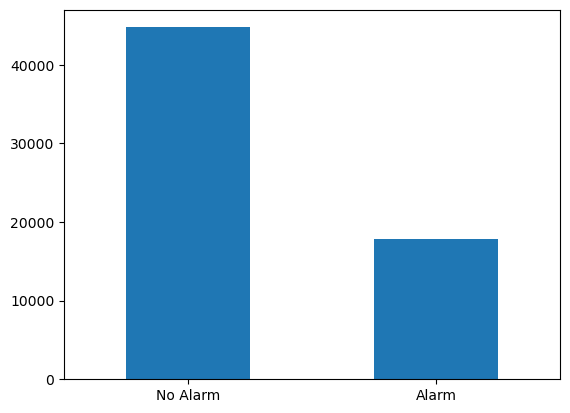

In [8]:
#Analyse The Target Variable, which is fire alarm
df["Fire Alarm"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ['No Alarm', 'Alarm'])
plt.xticks(rotation=0)

Terlihat bahwa kita sudah memiliki dataset yang baik, sebab data yang memperlihatkan bahwa fire alarm berbunyi lebih banyak dari yang tidak berbunyi, sehingga model kami dapat memprediksi apakah sebuah fire alarm berbunyi dengan baik

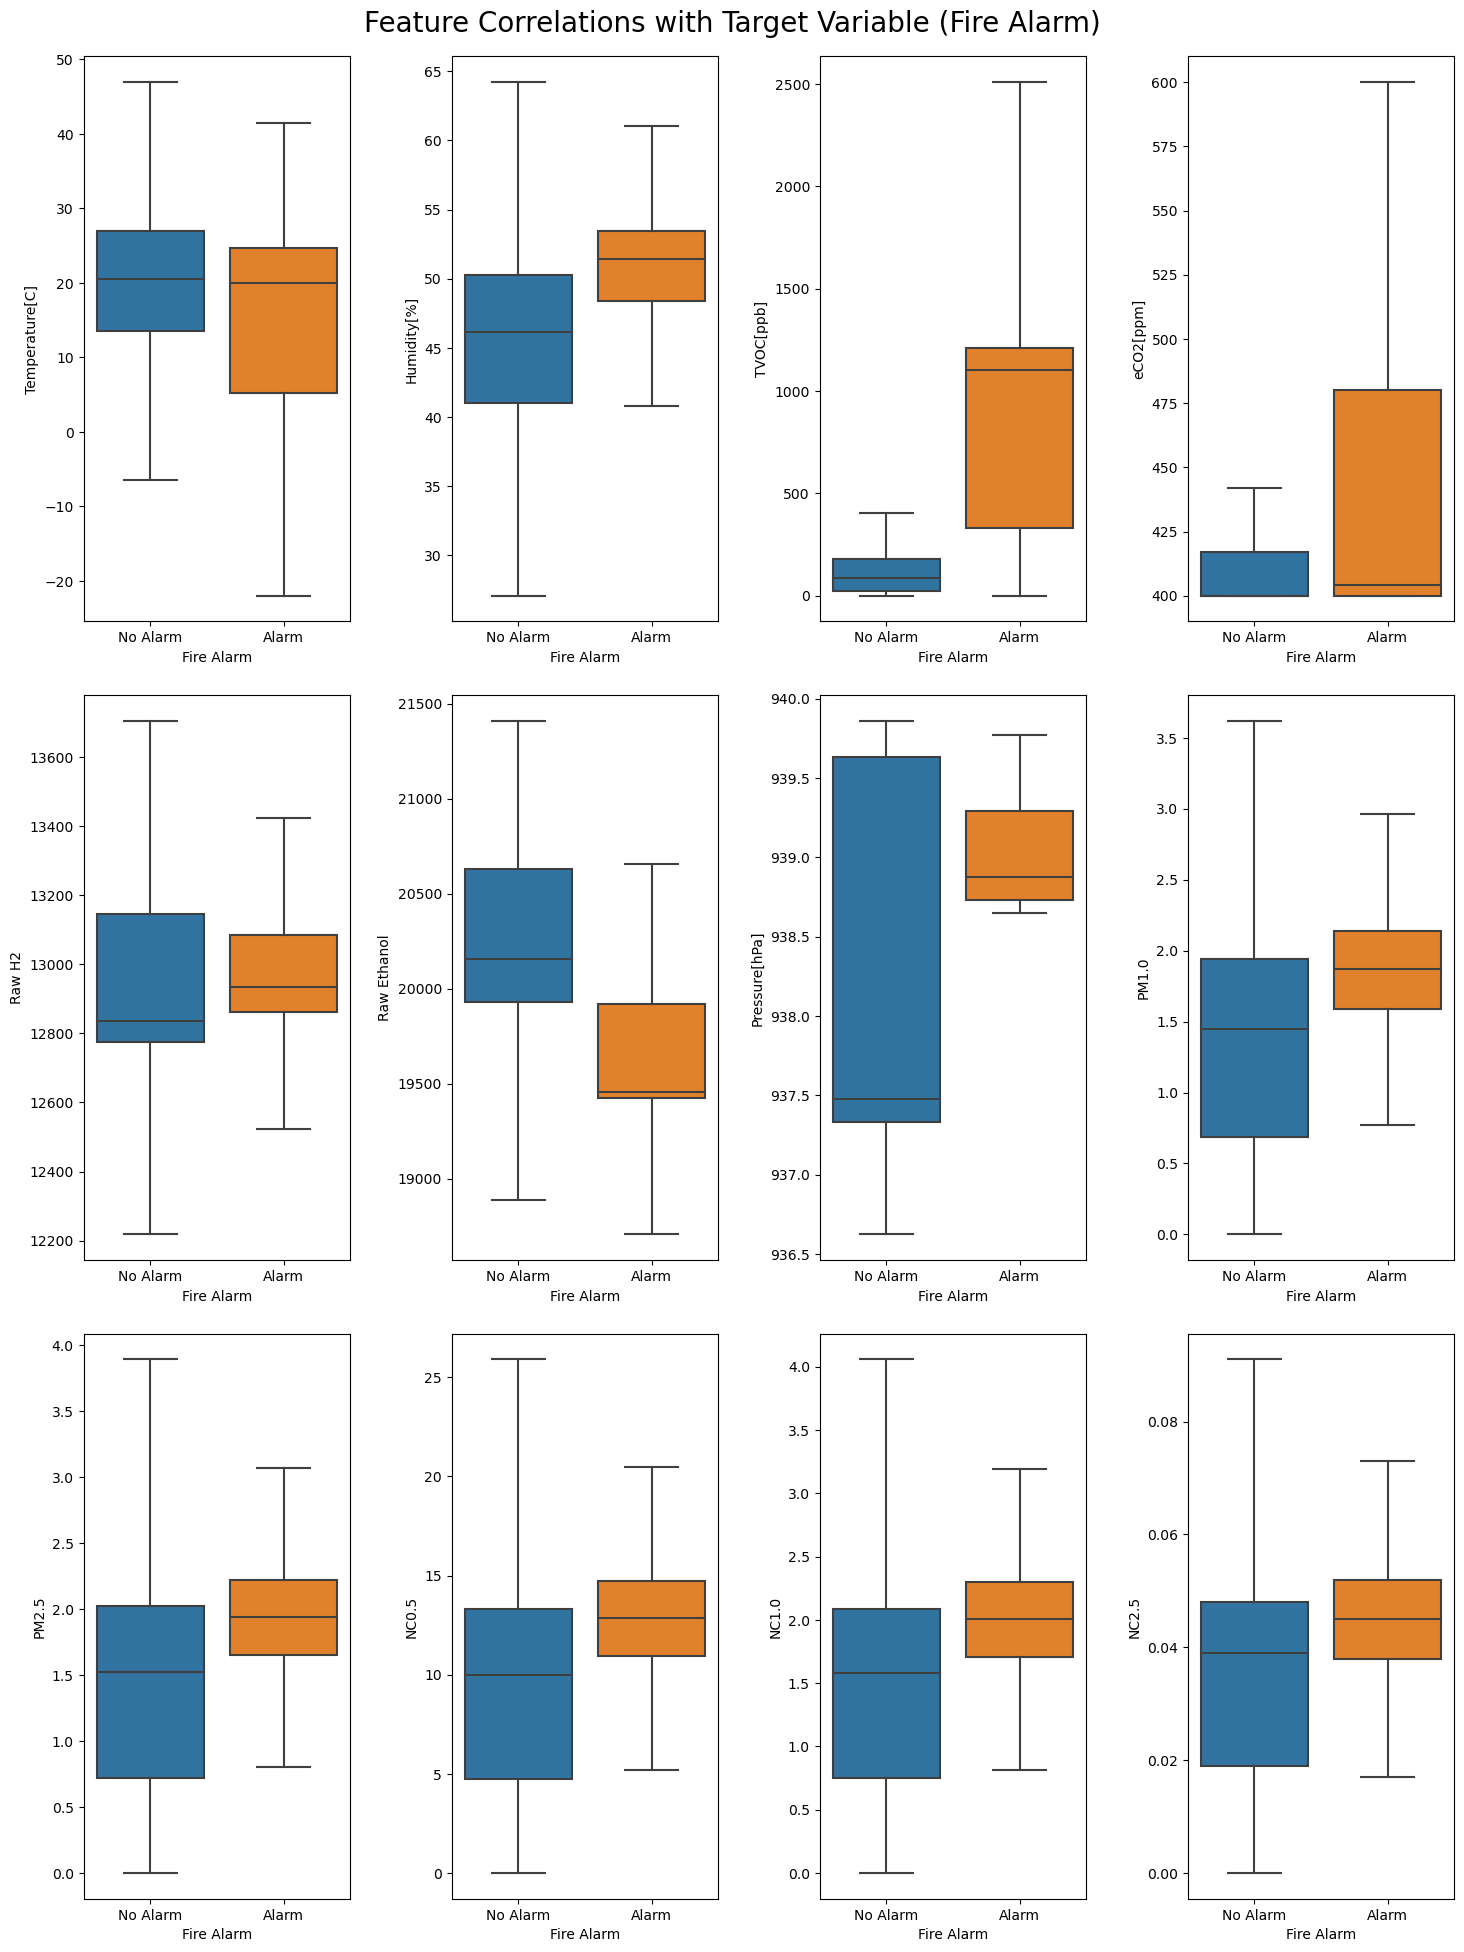

In [11]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 20))

for feature, subplot in zip(df, ax.flatten()):
    if feature == 'Fire Alarm':
        continue
    sns.boxplot(x = df['Fire Alarm'], y = df[feature], showfliers = False, ax = subplot)
    subplot.set_xticks([0, 1], ['No Alarm', 'Alarm'])

plt.suptitle('Feature Correlations with Target Variable (Fire Alarm)', fontsize = 20)
plt.tight_layout(pad = 2)
plt.show()

Terlihat bahwa:
1. Alarm yang berbunyi memiliki TVOC yang jauh lebih tinggi daripada alarm yang tidak berbunyi
2. Alarm yang berbunyi memiliki Raw Ethanol yang lebih rendah daripada alarm yang tidak berbunyi
3. Rata-rata Tekanan udara (Pressure) alarm yang tidak berbunyi lebih rendah daripada alarm yang berbunyi

<AxesSubplot:>

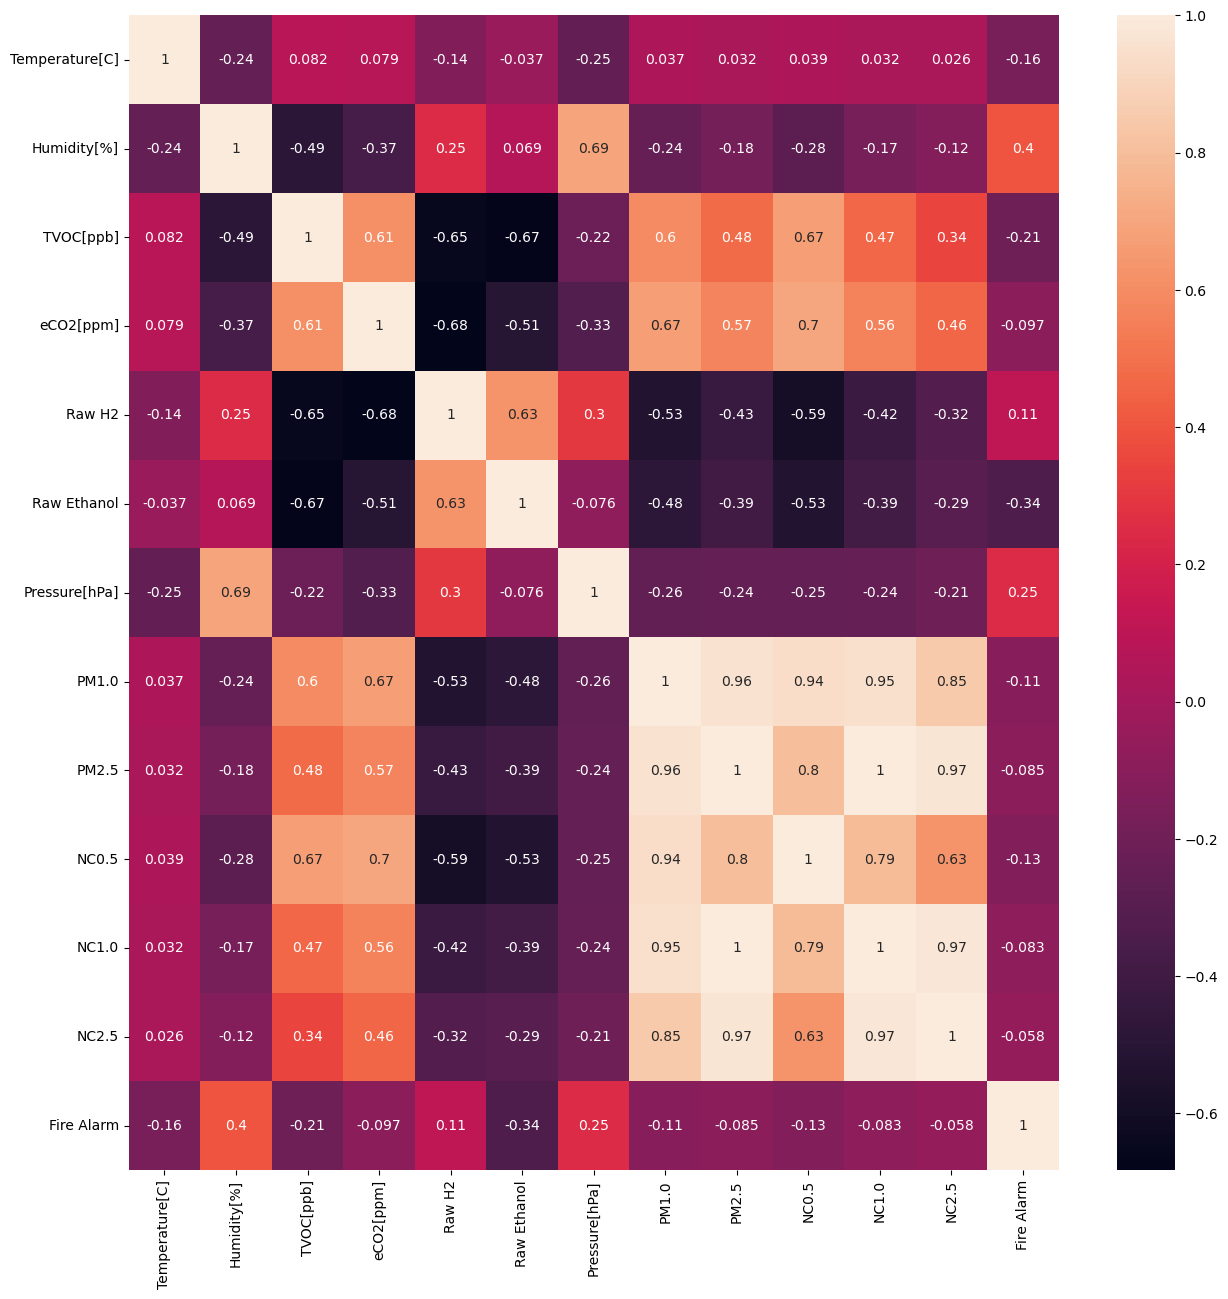

In [12]:
#Plotting correlation matrix heatmap

corr = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True)

Terlihat bahwa terdapat multicollinnearity yang kuat pada PM1.0 , PM2.5 , NC0.5, NC1.0, dan NC 2.5. Untuk percobaan pertama, kami tidak ingin menghapus terlebih dahulu variabel yang multicollinear untuk melihat performa model secara raw.

# Feature engineering

In [13]:
X = df.drop(['Fire Alarm'],axis=1)
Y = df['Fire Alarm']

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]


Pada tahap ini, kami tidak melakukan feature scaling, sebab kami memerlukan nama-nama atribut yang ada untuk visualisasi decision tree plot, kemudian untuk nama kolom yang memiliki unsur [] atau < perlu diganti dengan '_', agar XGBClassifier dapat digunakan

In [16]:
#Splitting train and test size with 20% test size
X_train,X_test,Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(50104, 12)
(12526, 12)
(50104,)
(12526,)


### DecisionTreeClassifier

In [18]:
dt = DecisionTreeClassifier()

dt_model = dt.fit(X_train,Y_train)

dt_pred = dt.predict(X_test)

In [19]:
print(classification_report(Y_test,dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



Terlihat bahwa model bekerja dengan sangat baik dengan akurasi 100%

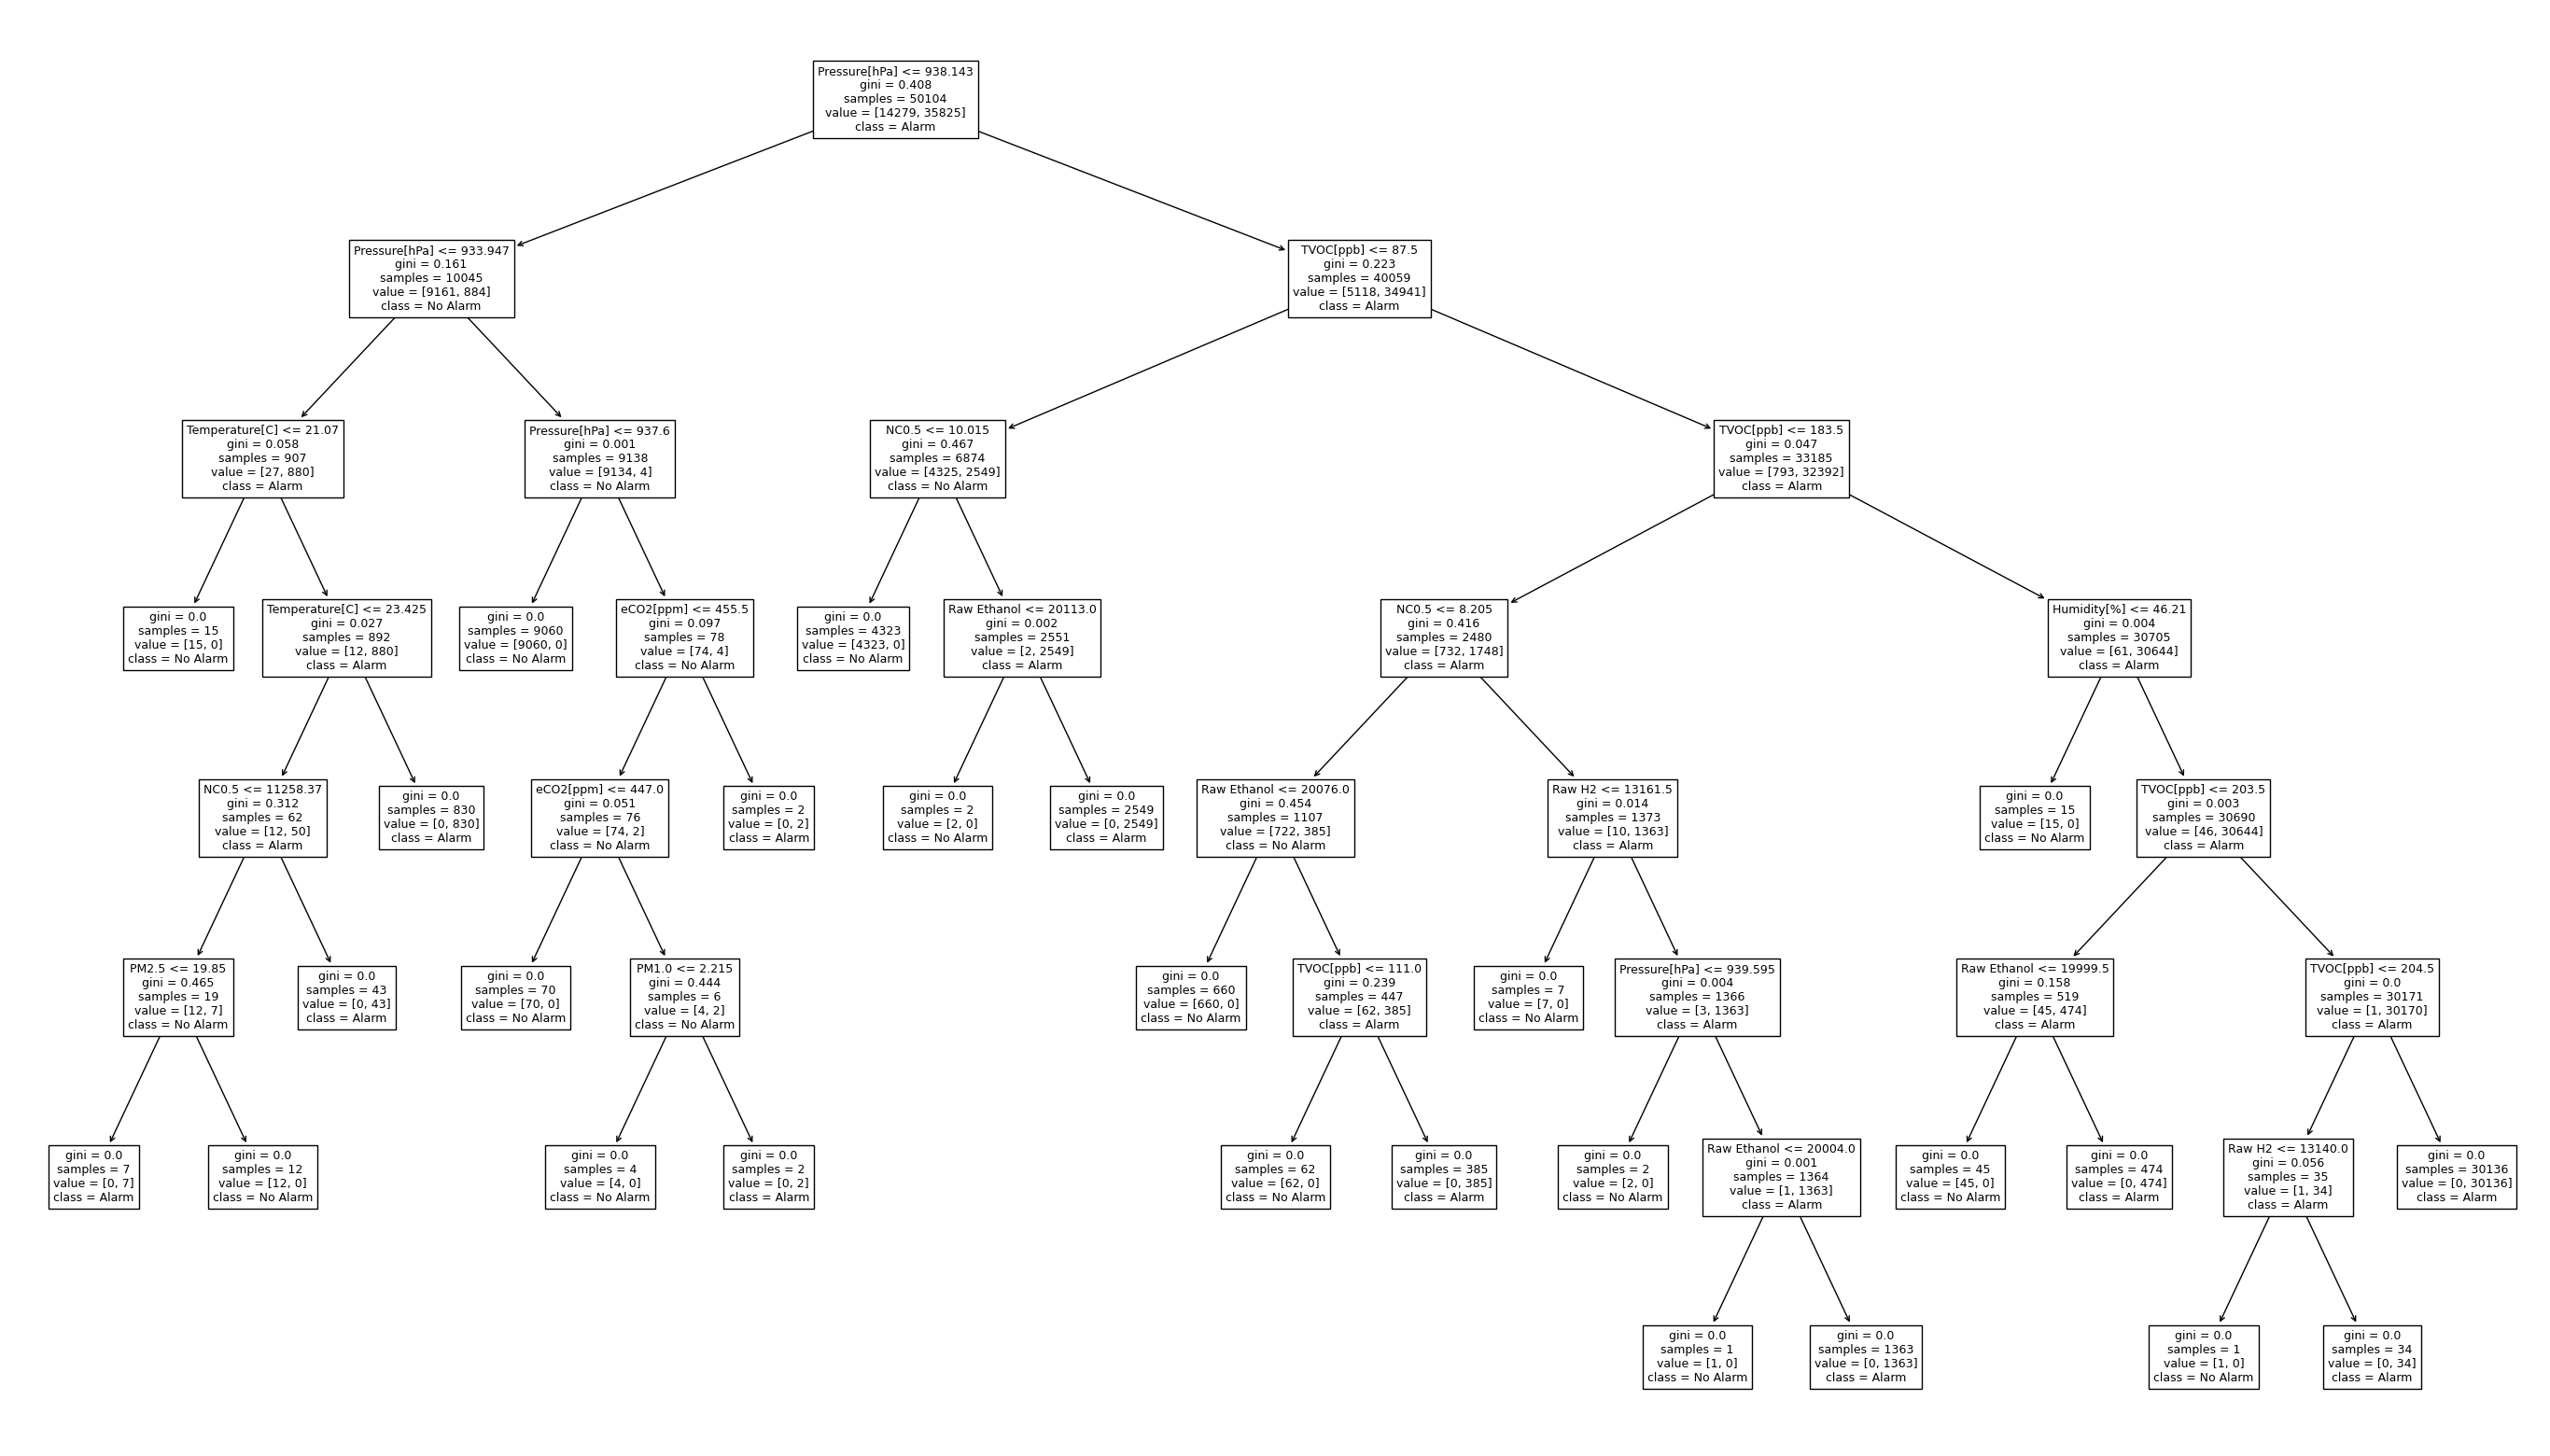

In [20]:
plt.figure(figsize=(35,20))
dtree_viz = plot_tree(dt_model, 
                      feature_names = df.drop(['Fire Alarm'],axis=1).columns,
                      class_names =['No Alarm','Alarm'])

plt.savefig('Model_dt.png')

Decision Tree plot could be shown on the .ipynb file , the plot shows that 30,136 from 35,825 rung alarm will ring in conditions : Pressure[hPa] > 938.143 hPa AND TVOC(ppb) > 204.5 ppb AND Humidity[%] >  46.21%  

The decision tree plot also shows that 9,060 from 14,279 non-rung alarm is under condition of : Pressure[hPa] <= 937.6 hPa  and the other 4,323 is under condition : Pressure[hPa] > 938.143 hPa AND TVOC[ppb] <= 87.5 ppb AND PM1.0 <= 1.455

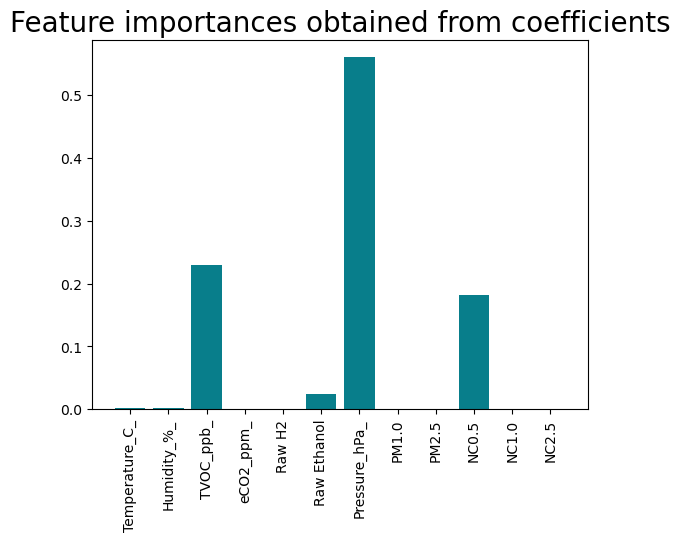

In [21]:
importance = dt_model.feature_importances_
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': dt_model.feature_importances_
})
# summarize feature importance
#for i,v in enumerate(importance):
 #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### XGBClassifier

In [22]:
#Modelling dengan XGBoostClassifier
xgb = XGBClassifier()

xgb.fit(X_train,Y_train)

xgb_pred = xgb.predict(X_test)

In [23]:
print(classification_report(Y_test,xgb_pred))
print(confusion_matrix(Y_test,xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3594
           1       1.00      1.00      1.00      8932

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526

[[3593    1]
 [   0 8932]]


Terlihat bahwa model bekerja dengan sangat sempurna dengan akurasi 100%(pembulatan, sebab terdapat 1 buah data yang salah).